In [1]:
import numpy as np
from matplotlib import pyplot as plt

### Problem 1

In [6]:
#Code from RK4 Lab with minor edits
def initialize_all(y0, t0, t, n):
    """ An initialization routine for the different ODE solving
    methods in the lab. This initializes Y, T, and h. """
    if isinstance(y0, np.ndarray):
        Y = np.empty((n, y0.size)).squeeze()
    else:
        Y = np.empty(n)
    Y[0] = y0
    T = np.linspace(t0, t, n)
    h = float(t - t0) / (n - 1)
    return Y, T, h

def RK4(f, y0, t0, t, n):
    """ Use the RK4 method to compute an approximate solution
    to the ODE y' = f(t, y) at n equispaced parameter values from t0 to t
    with initial conditions y(t0) = y0.
    y0 is assumed to be either a constant or a one-dimensional numpy array.
    t and t0 are assumed to be constants.
    f is assumed to accept three arguments.
    The first is a constant giving the value of t.
    The second is a one-dimensional numpy array of the same size as y.
    The third is an index to the other arrays.
    This function returns an array Y of shape (n,) if
    y is a constant or an array of size 1.
    It returns an array of shape (n, y.size) otherwise.
    In either case, Y[i] is the approximate value of y at
    the i'th value of np.linspace(t0, t, n).
    """
    Y,T,h = initialize_all(y0,t0,t,n)
    for i in range(n-1):
        K1 = f(T[i],Y[i],i)
        K2 = f(T[i]+h/2.,Y[i]+h/2.*K1,i)
        K3 = f(T[i]+h/2.,Y[i]+h/2.*K2,i)
        K4 = f(T[i+1],Y[i]+h*K3,i)
        Y[i+1] = Y[i] + h/6.*(K1+2*K2 +2*K3+K4)
    return Y

In [7]:
a_1, a_2 = 0, 0
b_1, b_2 = 0.02, 0.9
s_1, s_2 = 2., 1.5
mu = 0.002
k = 0.000025
g = 30.
c = 0.007
B_1, B_2 = 14, 1
A_1, A_2 = 250000, 75
T0, V0 = 400, 3
t_f = 50
n = 1000

# initialize global variables, state, costate, and u.
state = np.zeros((n,2))
state0 = np.array([T0, V0])
costate = np.zeros((n,2))
costate0 = np.zeros(2)
u=np.zeros((n,2))
u[:,0] += .02
u[:,1] += .9
# define state equations
def state_equations(t,y,i):
    '''
    Parameters
    ---------------
    t : float
        the time
    y : ndarray (2,)
        the T cell concentration and the Virus concentration at time t
    i : int
        index for the global variable u.
    Returns
    --------------
    y_dot : ndarray (2,)
    the derivative of the T cell concentration and the virus concentration at time t
    '''
    T_dot = s_1 - s_2*y[1]/(B_1+y[1]) - mu*y[0] - k*y[0]*y[1] + u[i,0]*y[0]
    V_dot = g*y[1]/(B_2+y[1])*(1-u[i,1]) - c*y[0]*y[1]
    return np.array([T_dot,V_dot])

### Problem 2

In [21]:
def lambda_hat(t,y,i):
    '''
    Parameters
    ---------------
    t : float
        the time
    y : ndarray (2,)
        the lambda_hat values at time t
    i : int
        index for global variables, u and state.
    Returns
    --------------
    y_dot : ndarray (2,)
        the derivative of the lambda_hats at time t.
    '''
    T,V = state[n-1-i,0],state[n-1-i,1]
    lmb1,lmb2 = y[0],y[1]
    lmb1_dot = lmb1*(-mu-k*V+u[n-1-i,0]) - c*lmb2*V - 1
    lmb2_dot = -lmb1*(s_2*B_1/(B_1+V)**2 + k*T) + lmb2*(g*B_2*(1-u[n-1-i,1])/(B_2+V)**2 - c*T)
    return np.array([lmb1_dot,lmb2_dot])

### Problem 3

In [24]:
epsilon = 0.001
test = epsilon + 1
count = 0
while(test > epsilon):
    oldu = u.copy();
    #solve the state equations with forward iteration
    #state = RK4(...)
    state = RK4(state_equations,state0,0,t_f,n)
    #solve the costate equations with backwards iteration
    #costate = RK4(...)[::-1]
    costate = RK4(lambda_hat,costate0,0,t_f,n)[::-1]
    #solve for u1 and u2
    u1 = np.zeros((n,))
    u2 = np.zeros((n,))
    for i in range(n) :
        u1[i] = min(max(a_1,-1/(2*A_1)*costate[i,0]*state[i,0]),b_1)
        u2[i] = min(max(a_2,costate[i,1]/(2*A_2)*g*state[i,1]/(B_2+state[i,1])),b_2)
    #update control
    u[:,0] = 0.5*(u1 + oldu[:,0])
    u[:,1] = 0.5*(u2 + oldu[:,1])
    #test for convergence
    test = abs(oldu - u).sum()
    count += 1

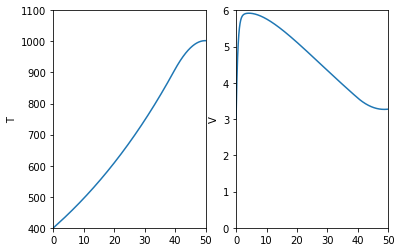

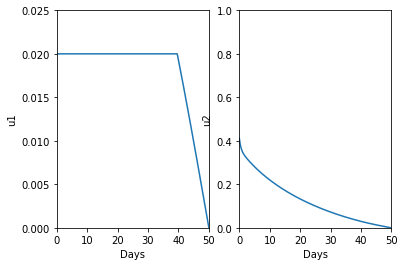

In [28]:
days = np.linspace(0,t_f,n)
plt.subplot(121)
plt.plot(days,state[:,0])
plt.ylabel('T')
plt.axis([0,50,400,1100])
plt.subplot(122)
plt.plot(days,state[:,1])
plt.ylabel('V')
plt.axis([0,50,0,6])
plt.show()
plt.subplot(121)
plt.plot(days,u[:,0])
plt.ylabel('u1')
plt.xlabel('Days')
plt.axis([0,50,0,0.025])
plt.subplot(122)
plt.plot(days,u[:,1])
plt.ylabel('u2')
plt.xlabel('Days')
plt.axis([0,50,0,1])
plt.show()